The competition is to be performed in groups of two. You'll have a report of 4 pages to submit by december 14th, presenting the methods you tested and used. For the defense you'll get 8 minutes of presentations + 7 minutes of questions, including on question on the labs, that may involve writing a code snippet.


Churn prediction 25/26
**Predict churn prediction from streaming service logs**

The goal of the competition is to predict whether or not some users (whose user ids are in the test file) will **churn in the window of 10 days that follows the given observations (ie after "2018-11-20")**. We consider that a user churns when they visit the page **'Cancellation Confirmation'** (edited) 


In [96]:
import pandas as pd

df_train_test = pd.read_parquet("data/test.parquet")
df_train = pd.read_parquet("data/train.parquet")

In [97]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17499636 entries, 0 to 25661583
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   status         int64         
 1   gender         object        
 2   firstName      object        
 3   level          object        
 4   lastName       object        
 5   userId         object        
 6   ts             int64         
 7   auth           object        
 8   page           object        
 9   sessionId      int64         
 10  location       object        
 11  itemInSession  int64         
 12  userAgent      object        
 13  method         object        
 14  length         float64       
 15  song           object        
 16  artist         object        
 17  time           datetime64[us]
 18  registration   datetime64[us]
dtypes: datetime64[us](2), float64(1), int64(4), object(12)
memory usage: 2.6+ GB


In [121]:
# Vérifie les noms de colonnes exacts et leur longueur
for col in sample_df_train.columns:
    print(repr(col), len(col))


'status' 6
'gender' 6
'firstName' 9
'level' 5
'lastName' 8
'userId' 6
'ts' 2
'auth' 4
'page' 4
'sessionId' 9
'location' 8
'itemInSession' 13
'userAgent' 9
'method' 6
'length' 6
'song' 4
'artist' 6
'time' 4
'registration' 12
'will_churn_10days' 17
'hour' 4
'month' 5


In [98]:
# Creating cancellation in following ten days column

import numpy as np

cancellation_events = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
cancellation_events = cancellation_events[['userId', 'time']].rename(columns={'time': 'churn_time'})

df_train = df_train.merge(cancellation_events, on='userId', how='left')

df_train['days_until_churn'] = (df_train['churn_time'] - df_train['time']).dt.total_seconds() / (24 * 3600)

df_train['will_churn_10days'] = ((df_train['days_until_churn'] >= 0) & 
                                   (df_train['days_until_churn'] <= 10)).astype(int)

df_train = df_train.drop(['churn_time', 'days_until_churn'], axis=1)

In [99]:
df_train.describe() #max time is 2018-11-20 so we are going to keep only the rows that are at least 10 days old OR that have churn True

df_train = df_train[(df_train["time"] < "2018-11-10" )| (df_train["will_churn_10days"] == 1)]

In [100]:
#Checking that code worked as expected
df_train.sort_values(by='time', ascending = True).head(10)

#!!!!!!!
# Since we only keep rows that have churn True in the last 10 days, our model could learn that a later date means more chance to churn! MERDE


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration,will_churn_10days
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,0
15193945,200,M,Austen,free,Horton,1484921,1538352001000,Logged In,NextSong,2436,"New York-Newark-Jersey City, NY-NJ-PA",73,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",PUT,238.54975,Just Dance,Lady GaGa / Colby O'Donis,2018-10-01 00:00:01,2018-09-16 09:11:42,0
15194608,200,M,Jose,free,Goodman,1694515,1538352001000,Logged In,NextSong,2466,"Lafayette, LA",1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,231.65342,Give It Up (Album Version),The Format,2018-10-01 00:00:01,2018-09-15 04:03:02,0
1796,200,F,Vina,paid,Bailey,1697168,1538352002000,Logged In,NextSong,4593,"Hilo, HI",109,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,PUT,140.35546,Baby Talk,Lush,2018-10-01 00:00:02,2018-09-08 13:48:25,0
1223,200,F,Vianney,paid,Miller,1563081,1538352002000,Logged In,NextSong,20836,"San Francisco-Oakland-Hayward, CA",9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,238.39302,MiÃÂ©ntele,Los Bunkers,2018-10-01 00:00:02,2018-09-21 03:25:18,0
15195378,200,F,Noeli,free,Harrison,1379661,1538352003000,Logged In,NextSong,133,"Dallas-Fort Worth-Arlington, TX",140,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,241.24036,All Along The Watchtower,Jimi Hendrix,2018-10-01 00:00:03,2018-07-26 17:36:54,0
15198031,200,F,Samantha,paid,Villanueva,1252007,1538352003000,Logged In,Home,3935,"Fort Collins, CO",36,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,GET,NaN,None,None,2018-10-01 00:00:03,2018-07-19 15:35:33,0
5924,200,F,Aaliyah,paid,Ramirez,1714398,1538352003000,Logged In,NextSong,22316,"Baltimore-Columbia-Towson, MD",21,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,1121.25342,Close To The Edge (I. The Solid Time Of Change...,Yes,2018-10-01 00:00:03,2018-09-19 18:23:35,0
3761,200,M,Andres,paid,Foley,1222580,1538352003000,Logged In,NextSong,6370,"Watertown, SD",71,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,277.15873,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,2018-10-01 00:00:03,2018-08-16 02:31:00,0
15195379,307,F,Noeli,free,Harrison,1379661,1538352004000,Logged In,Logout,133,"Dallas-Fort Worth-Arlington, TX",141,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,NaN,None,None,2018-10-01 00:00:04,2018-07-26 17:36:54,0


In [101]:
df_train.describe()

,status,ts,sessionId,itemInSession,length,time,registration,will_churn_10days
count,1.465755e+07,1.465755e+07,1.465755e+07,1.465755e+07,1.195098e+07,14657548,14657548,1.465755e+07
mean,2.091415e+02,1.540076e+12,7.294373e+04,1.045211e+02,2.487060e+02,2018-10-20 22:51:07.219720,2018-08-25 02:18:34.093644,1.235250e-01
min,2.000000e+02,1.538352e+12,1.000000e+00,0.000000e+00,5.220000e-01,2018-10-01 00:00:01,2017-10-14 22:05:25,0.000000e+00
25%,2.000000e+02,1.539193e+12,2.127200e+04,2.500000e+01,1.998624e+02,2018-10-10 17:35:49.750000,2018-08-10 22:00:31,0.000000e+00
50%,2.000000e+02,1.540025e+12,6.789700e+04,6.500000e+01,2.340828e+02,2018-10-20 08:43:09,2018-09-05 15:53:20,0.000000e+00
75%,2.000000e+02,1.540941e+12,1.190990e+05,1.420000e+02,2.768714e+02,2018-10-30 23:12:18,2018-09-20 15:27:40,0.000000e+00
max,4.040000e+02,1.542672e+12,2.047110e+05,1.426000e+03,3.024666e+03,2018-11-19 23:55:09,2018-11-14 23:31:27,1.000000e+00
std,3.023523e+01,1.020072e+09,5.300614e+04,1.165782e+02,9.725864e+01,NaN,NaN,3.290388e-01


In [102]:
# We drop columns that are not features

In [103]:
# We add columns that could be explanatory
df_train['hour'] = df_train['time'].dt.hour
df_train['month'] = df_train['time'].dt.month

In [104]:
df_train.columns

Index(['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts',
       'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent',
       'method', 'length', 'song', 'artist', 'time', 'registration',
       'will_churn_10days', 'hour', 'month'],
      dtype='object')

## Preliminary EDA

In [105]:
numerical_columns = ['ts', 'itemInSession', 'status', 'length','hour', 'month']
categorical_columns = ['auth', 'page', 'location', 'userAgent',
                       'method', 'song', 'artist']
target_column = ['will_churn_10days']
time_columns = ['time', 'registration']
all_columns = numerical_columns + categorical_columns + target_column + time_columns

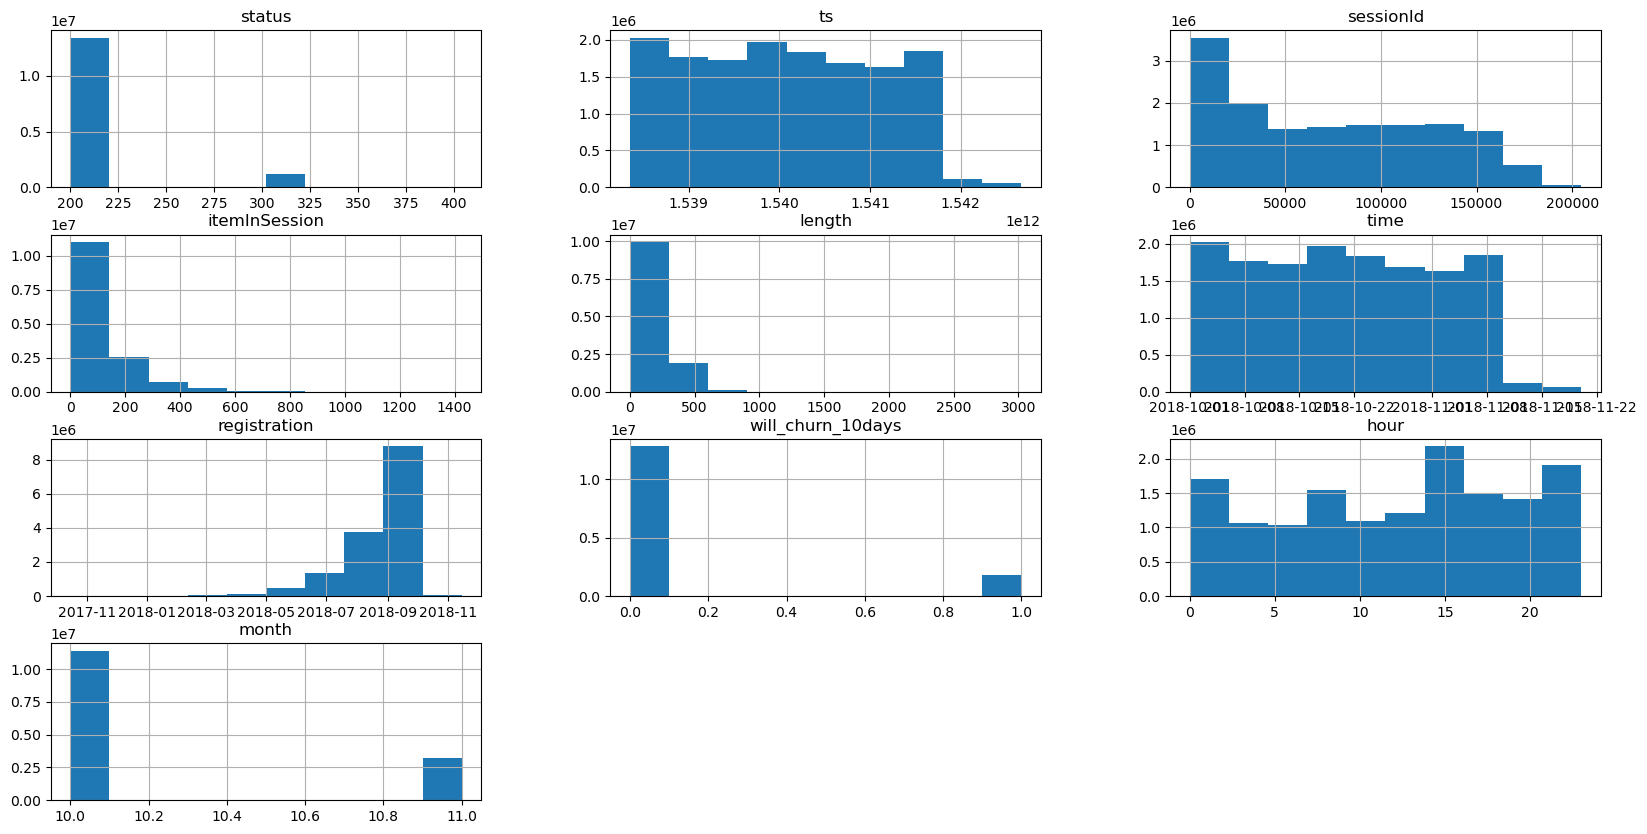

In [106]:
df_train.hist(figsize=(20, 10)); 

In [109]:
unique_counts = df_train.nunique()

print(unique_counts)

status                     3
gender                     2
firstName               4930
level                      2
lastName                1000
userId                 18884
ts                   3521777
auth                       2
page                      19
sessionId             137694
location                 875
itemInSession           1427
userAgent                 85
method                     2
length                 23169
song                  232003
artist                 36716
time                 3521777
registration           18862
will_churn_10days          2
hour                      24
month                      2
dtype: int64


In [110]:
df_train['itemInSession'].value_counts()

itemInSession
2       164595
3       163243
4       161394
5       158941
6       156489
         ...  
1374         2
1373         2
1328         2
1425         1
1426         1
Name: count, Length: 1427, dtype: int64

In [111]:
df_train['auth'].value_counts()

auth
Logged In    14653277
Cancelled        4271
Name: count, dtype: int64

In [112]:
df_train['page'].unique()

array(['NextSong', 'Downgrade', 'Help', 'Home', 'Thumbs Up', 'Add Friend',
       'Thumbs Down', 'Add to Playlist', 'Logout', 'About', 'Settings',
       'Save Settings', 'Cancel', 'Cancellation Confirmation',
       'Submit Downgrade', 'Roll Advert', 'Upgrade', 'Error',
       'Submit Upgrade'], dtype=object)

In [113]:
df_train['page'].value_counts()

page
NextSong                     11950984
Thumbs Up                      657936
Home                           543452
Add to Playlist                341986
Roll Advert                    253569
Add Friend                     219631
Logout                         172674
Thumbs Down                    139064
Downgrade                      103258
Settings                        84952
Help                            74615
Upgrade                         33542
About                           27807
Save Settings                   17069
Error                           14512
Submit Upgrade                  10215
Cancellation Confirmation        4271
Cancel                           4271
Submit Downgrade                 3740
Name: count, dtype: int64

## Feature preprocessing

In [159]:
# Sampling the dataset to try the functions:
sample_users = df_train['userId'].drop_duplicates().sample(n=200, random_state=42)
sample_df_train = df_train[df_train['userId'].isin(sample_users)].copy()

In [161]:
# Selection of columns to simplify the dataset
columns_selection = ['userId', 'time', 'page', 'registration', 'sessionId',
              'itemInSession', 'will_churn_10days']
sample_df_train = sample_df_train[columns_selection]
sample_df_train.sample(10)

,userId,time,page,registration,sessionId,itemInSession,will_churn_10days
16807979,1262845,2018-10-30 00:38:56,NextSong,2018-08-22 15:42:35,23904,5,0
15026606,1657113,2018-10-22 21:01:24,NextSong,2018-09-01 10:06:22,14716,106,0
865003,1108863,2018-10-08 09:58:59,NextSong,2018-08-27 09:39:25,54293,120,0
9944189,1527589,2018-10-22 16:13:36,NextSong,2018-09-24 06:01:27,105414,55,0
7683510,1265825,2018-10-27 15:58:48,NextSong,2018-07-20 15:46:11,68936,323,0
13803748,1338157,2018-10-25 01:31:04,NextSong,2018-05-28 00:11:26,10122,53,0
9589294,1186249,2018-10-08 00:52:25,Add to Playlist,2018-09-03 05:20:07,47744,63,0
659410,1920313,2018-10-19 11:37:02,NextSong,2018-09-19 09:07:58,95594,267,0
5765210,1138004,2018-10-01 21:31:17,Add to Playlist,2018-09-22 19:44:53,1201,11,0
12931532,1071454,2018-10-23 13:14:34,NextSong,2018-09-30 21:04:57,16280,6,0


### Optimized function

In [173]:
import pandas as pd
import numpy as np
from datetime import timedelta


def optim_create_churn_features(df_train, lookback_days=15):
    """
    Creates aggregated features for churn prediction (OPTIMIZED VERSION).
    One row is created per session with features calculated on the N previous days.
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Dataset with columns: userId, time, page, registration, sessionId, 
        itemInSession, will_churn_10days
        - registration: user's subscription date (fixed per user, used as feature)
        - time: timestamp of each log
        - sessionId: unique identifier for each session
    lookback_days : int
        Number of historical days to consider for calculating features
    
    Returns:
    --------
    pd.DataFrame
        Dataset with aggregated features, one row per session
    """
    
    print("Starting feature engineering (optimized)...")
    
    # Copy and prepare data
    df = df_train.copy()
    
    # Sort once at the beginning
    df = df.sort_values(['userId', 'time']).reset_index(drop=True)
    
    print(f"Dataset size: {len(df)} logs")
    
    # Get session info: first log chronologically per session
    session_info = df.groupby('sessionId').agg({
        'userId': 'first',
        'registration': 'first',  # User's subscription date (fixed)
        'time': 'first',  # First log time = session start
        'will_churn_10days': 'first'  # Label from first log
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start', 'will_churn_10days']
    
    print(f"Processing {len(session_info)} sessions...")
    
    # Create window boundaries for each session based on session_start
    session_info['window_start'] = session_info['session_start'] - timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    
    # Calculate days since registration (account age at session start)
    session_info['days_since_registration'] = (
        session_info['session_start'] - session_info['registration']
    ).dt.days
    
    results = []
    
    # Group by userId to process all sessions of a user together
    for user_id, user_sessions in session_info.groupby('userId'):
        # Get all logs for this user
        user_logs = df[df['userId'] == user_id].copy()
        
        if len(user_logs) == 0:
            continue
        
        # For each session of this user
        for _, session_row in user_sessions.iterrows():
            session_id = session_row['sessionId']
            session_start = session_row['session_start']
            registration_date = session_row['registration']
            label = session_row['will_churn_10days']
            window_start = session_row['window_start']
            window_end = session_row['window_end']
            days_since_registration = session_row['days_since_registration']
            
            # Filter logs in the lookback window (before session start)
            window_logs = user_logs[
                (user_logs['time'] >= window_start) &
                (user_logs['time'] < window_end)
            ]
            
            # Calculate inactivity: time since last action before this session
            previous_logs = user_logs[user_logs['time'] < window_end]
            
            if len(previous_logs) > 0:
                hours_since_last_action = (
                    session_start - previous_logs['time'].max()
                ).total_seconds() / 3600
            else:
                hours_since_last_action = np.nan
            
            # Vectorized page counting
            page_counts = window_logs['page'].value_counts().to_dict()
            
            # Helper function for safe counting
            def get_count(page_name):
                return page_counts.get(page_name, 0)
            
            total_actions = len(window_logs)
            
            # Calculate aggregated features
            features = {
                'sessionId': session_id,
                'userId': user_id,
                'session_start': session_start,
                'registration': registration_date,
                'will_churn_10days': label,
                
                # Temporal features
                'hours_since_last_action': hours_since_last_action,
                'days_since_registration': days_since_registration,  # Account age
                
                # Page type counts - Basic actions
                'count_next_song': get_count('NextSong'),
                'count_home': get_count('Home'),
                'count_help': get_count('Help'),
                'count_about': get_count('About'),
                'count_error': get_count('Error'),
                'count_logout': get_count('Logout'),
                
                # Positive engagement
                'count_thumbs_up': get_count('Thumbs Up'),
                'count_thumbs_down': get_count('Thumbs Down'),
                'count_add_playlist': get_count('Add to Playlist'),
                'count_add_friend': get_count('Add Friend'),
                
                # Settings and configuration
                'count_settings': get_count('Settings'),
                'count_save_settings': get_count('Save Settings'),
                
                # Subscription actions
                'count_downgrade': get_count('Downgrade'),
                'count_upgrade': get_count('Upgrade'),
                'count_submit_downgrade': get_count('Submit Downgrade'),
                'count_submit_upgrade': get_count('Submit Upgrade'),
                
                # Advertisements
                'count_roll_advert': get_count('Roll Advert'),
                
                # Global statistics
                'total_actions': total_actions,
                'unique_pages': window_logs['page'].nunique() if total_actions > 0 else 0,
                
                # Temporal statistics
                'days_active': window_logs['time'].dt.date.nunique() if total_actions > 0 else 0,
                'avg_actions_per_day': total_actions / lookback_days,
                
                # Sessions in the window
                'num_sessions': window_logs['sessionId'].nunique() if total_actions > 0 else 0,
                
                # Ratios and trends - Engagement
                'ratio_thumbs_up': get_count('Thumbs Up') / total_actions if total_actions > 0 else 0,
                'ratio_thumbs_down': get_count('Thumbs Down') / total_actions if total_actions > 0 else 0,
                'ratio_errors': get_count('Error') / total_actions if total_actions > 0 else 0,
                'ratio_engagement': (
                    (get_count('Add to Playlist') + get_count('Add Friend') + get_count('Thumbs Up')) / total_actions
                    if total_actions > 0 else 0
                ),
                
                # Critical ratios for churn
                'ratio_downgrade_actions': (
                    (get_count('Downgrade') + get_count('Submit Downgrade')) / total_actions
                    if total_actions > 0 else 0
                ),
                'ratio_help_actions': (
                    (get_count('Help') + get_count('Settings')) / total_actions
                    if total_actions > 0 else 0
                ),
                
                # Binary flags
                'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
            }
            
            results.append(features)
    
    # Create final DataFrame
    df_features = pd.DataFrame(results)
    
    # Set sessionId as index
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features)} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")
    print(df_features['will_churn_10days'].value_counts())
    
    return df_features

### Test of the function on a small dataset

In [174]:
example = optim_create_churn_features(sample_df_train)

Starting feature engineering (optimized)...
Dataset size: 154875 logs
Processing 1736 sessions...

✓ Final dataset: 1736 rows, 32 features
Label distribution:
will_churn_10days
0    1562
1     174
Name: count, dtype: int64


In [172]:
example.sample(10)

,userId,session_start,registration,will_churn_10days,hours_since_last_action,days_since_registration,count_next_song,count_home,count_help,count_about,...,avg_actions_per_day,num_sessions,ratio_thumbs_up,ratio_thumbs_down,ratio_errors,ratio_engagement,ratio_downgrade_actions,ratio_help_actions,has_downgrade_action,has_upgrade_action
sessionId,,,,,,,,,,,,,,,,,,,,,
29199,1807126,2018-11-07 09:20:19,2018-08-09 18:43:03,0,13.951944,89,97,5,1,0,...,7.866667,6,0.025424,0.008475,0.000000,0.084746,0.008475,0.016949,1,0
124046,1069336,2018-11-01 11:39:31,2018-09-23 12:32:42,0,162.471111,38,7,1,1,0,...,0.866667,1,0.153846,0.000000,0.000000,0.307692,0.000000,0.076923,0,0
11751,1011733,2018-10-18 08:44:08,2018-08-03 17:07:12,1,4.105278,75,166,8,0,0,...,13.600000,4,0.034314,0.009804,0.000000,0.093137,0.019608,0.000000,1,1
2504,1086740,2018-10-08 11:49:04,2018-10-08 11:49:04,1,NaN,0,0,0,0,0,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
127236,1063362,2018-10-30 03:04:39,2018-08-07 09:24:19,0,86.297500,83,659,29,5,1,...,52.400000,8,0.048346,0.002545,0.000000,0.086514,0.007634,0.015267,1,0
13598,1353750,2018-10-26 16:01:14,2018-09-27 15:29:19,1,52.565833,29,163,6,0,0,...,12.866667,2,0.020725,0.010363,0.000000,0.056995,0.015544,0.005181,1,0
92514,1477513,2018-10-18 22:03:26,2018-09-04 14:19:21,0,82.879167,44,198,10,0,0,...,16.666667,7,0.064000,0.004000,0.004000,0.100000,0.000000,0.004000,0,0
10092,1830029,2018-10-10 14:40:46,2018-08-14 20:52:40,0,30.332500,56,320,24,3,1,...,29.266667,8,0.095672,0.009112,0.000000,0.132118,0.000000,0.020501,0,1
14474,1160352,2018-10-19 14:09:09,2018-08-13 15:50:07,0,44.730556,66,15,2,0,0,...,1.533333,2,0.000000,0.043478,0.000000,0.043478,0.086957,0.000000,1,0


It seems to work but it is way too slow

### Application of the function to the whole dataset

In [169]:
X = optim_create_churn_features(df_train)

Starting feature engineering (optimized)...
Dataset size: 14657548 logs
Processing 137694 sessions...


KeyboardInterrupt: 